In [1]:
import datetime
import gc
import json
import os
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

# Tokens we accept 
valid_tokens = [
    ### Stablecoins
    'USDT', 'USDC', 'TUSD', 'PAX', 'BUSD', 'DAI', 'HUSD',
    ### Exchange coins
    #'LEO', 'BNB',
]

# USDT Chain Swap Transactions to remove
chain_swaps = [
    # Aug 5th 2021
    '0xd3f5b524240dd4d84828afddb7ebd2dc28a072bb605da24610210917525352a5',
    '0x56e4d10e878d74b88ce60a61a433c52f99aa2ad12bdcb9e0d3f46097203f2c33',
    '801da82f1ebbd63f6c46777b3f072b24cc4cf00c11ba418a7153cd74a83e8609',
    'f6aff4b44e57086756ecdb656101a2bb6dd9c6162ee50cee5b40669e1f9e2f51',
    'bcfb4e9aae72af3921d26ac0525386d84060b9464a41deb77c986330f9180285',
    # Feb 2nd 2021
    '0xab79b408596755b4e1c6dc2dfe597c5332f5ea9b8029c5788d49b07dde8f0b41',
    '0x497e50b78dc13a3e649f5fedc68f93f5dfc47fde4420d2537e446df7d466138c',
    '0xeeccbb3fa40d920729de71e0f8d33e65e1af3c9213786f26b28fea00ab7398b2',
    '0x9f36efea4064cf2f2b15b3bf1f538519c80abfcd63d70c9b08491bf3c3c8a0bf',
    '0x4224907af4bd915069a2d553b654e38d3dab99cda93aa12b38e6fbefaecb406f',
    # May 31st 2021
    'a363314da10acb8fa9f600d2a6504fa2a89eba56f07dddfb685fa451afd4ca38',
    'f7f077e435dea31e6abb3ca4a12548b38e943aab4946504f830d1ee99c914f15',
    '21243fc5900103f4fcf4aa01ab2cf519e79fe09c1582364acfaf7804c9db761c',
    '514acefa7ce76825fcaac081e22cafc406498c36802fad8ad6d27d2520849e4e',
    '2f1e3323071615e6f6c885d8db72d11794a8f71055a7840f2d6729f8dcc335f9',
    '28d148c28c2177bf1a88fc961e507a7b0128b4dbec24e90e68581f2f465851aa',
    'ac1960e05493a8c7667cd97d6127d0aad0b70bb92e4c915e1ee88e6c769bea3e',
    '8404e3e94af22ff107587bba2750ec99587dac71f0376418721f436765ae33d9',
    'fc36835b1552f10d075269488deae0b09287c28390a33f1f2e813a5d3187e12c',
    '0xc2cad384105ed120e786b158c259a2fb7e40a4d80d5e6c35b3b4dcbbc08f741b',
    '0x9e9d2b8e277beccfd74d789b68fde07bcc8514c38a072f9dbdf2e37e83d58de0',
    '0x03cde7a5c6a99beb0862bcc98244b7584cad76e0fd411b3ef3d87c2953994704',
    '0xf6dd27c3592956ab4a5639c852b8538dffdfe618a2d524a70340fc5339f3a5c9',
    '0x6902338c804013d7522c29c8dd3c7cb4f4915ac37dc87d8f1914fa95c47b76ab',
    '0xd39bc72b523058bd7ee104a34e8cfcbc71753f7d1eaad3bdf1f0314c3f41f910',
    '0xa003a269f31cfa11f55cc7766d9e8f42d39d29d73ed6eb06a55955c009284686',
    '0xcfff47068a9b6c1b4453f1508b9dbfacc46f337ad282b011ae8a7afe044d2e85',
    '0x016327217434bc66fb5118e11b30fae41ce21073c31beb7112e397df561438f6',
    '0x6def065b1c03874af7401624a14da222c49f101745efdb076954485aa2fd2ae9',
    '0x1725af8aebcb0309e560c4117163ca029a339be55d4b4d152e029cf06e77c2d4',
    # May 19th 2021
    '0x1a7dd106b356f22bc5d1da679768a4e664fa1e37d5f20303b948c1a1fc5ca22b',
    '0x88b162b24be4030dc70532975a940a555f16df4661909e480094a3669acd6fc0',
    '3c2853bae1371a1159c0e6ef37857cc8e3e37001d17ffb316eead51e9dfd3d3d',
    'ccb52bfe995ef28697af240b92e1f82147e716c65a32120c943fc03dc2b525bb',
    # May 17th 2021
    '164cceda7fcd0f3c974f804c335e2eeff3fdb9610d06db06beb873972c380c8a',
    '159edc6953f07f73b497fe5f140511ecabd44e39b378c859c2a6e97c465bfef6',
    '0xf2b7e6b767dca1317920b1d053d807d75b2a2e29453909c793e8feaa31c13a41',
    '0xb71ea4a9a32ef360e4cfa2a1b21fd7e13e5f8e38be9be3c3bedd97d0ab0a231a',
    # Sept 15th 2020
    'e85588c6493b7f1a552c2c7340c8d7392fb1bc1363bf77ae65454ec7d791a7fc',
    '36ea669de6907cb4a768fa908b3e29b71881b401a786ba79367b08fdbb157294',
    'e456841dc09406f8568f6537f9f6f3c3b1379aef307a72e7da609da59674193d',
    '0x63e5a19430eb3f5fe6be4d5f9d132214545ae77af25a064697dd2d32c10b0801',
    '0xf1acb723691a56c029675392b231f2c5611cb76d186828e525b68f5f808f5ae3',
    '0x0428a07827f56fb58dbe12ae8ffbbeaf2fa497dd2db8e2a542651827c5828af7',
    # Aug 20th 2020
    'ef65a6ef3add4a39c0a4bfd1015431877faa7924ace1276d5b08b1df974eadbc',
    'b7a67bbb58abb4ef1570a1e5fb6a8dc1425dcf89b98695eafb157d507598c20b',
    'fa3c39073d4f7d72dce3322f5d29e11e58d6dd3c516edc7694b993c77417a01b',
    '0xc7d374d1ac37a0eeb1e3ddaba2f1651142c3c7c122214d0d952e83c4aa5d490b',
    '0xd418743d31c91252eb466ad1bbc58d21ce2512d678bb0c503baabc44419c2364',
    '0xca8e3c2de2383ea2762ac66f441bd1fc9d95369423d0be7b30166a1dae6052ee',
    '0xb58cd249406eb7294a99e699732a3d83c0fde1539af2a93215f5267e292a9656',
    '0x7bed5871d75371dc6bfc4e52f175f3d827ad58f278b603de81f4eb3978ab49ba',
]

# known addresses
# Mix of whaleAPI labels and manual labels
with open("data/known_addresses.json", 'r') as f:
    known_addresses = json.load(f)

def safe_map(x):
    """Map known addresses to owners"""
    try: return known_addresses[x]
    except: return x
    
### Read & Clean ETH blockchain data
# From https://etherscan.io/address/0x5754284f345afc66a98fbb0a0afe71e0f007b949#tokentxns
eth = pd.read_csv("data/eth.csv", index_col=False)
# remove chain swaps
eth = eth.loc[~eth.Txhash.isin(chain_swaps)]
eth['date'] = pd.to_datetime(eth.DateTime)
eth = eth.drop(columns=['DateTime', 'Txhash', 'UnixTimestamp', 'ContractAddress', 'TokenName'])
eth.columns = ['from', 'to', 'value', 'token', 'date']
eth['chain'] = 'eth'
eth = eth[['date', 'value', 'token', 'from', 'to', 'chain']]
eth.to = eth.to.apply(safe_map)
eth['from'] = eth['from'].apply(safe_map)

### Read & Clean Tron blockchain data
# From https://tronscan.org/#/address/TKHuVq1oKVruCGLvqVexFs6dawKv6fQgFs/transfers
tron = pd.read_csv("data/tron.csv")
# remove chain swaps
tron = tron.loc[~tron.transaction_id.isin(chain_swaps)]
tron = tron.drop(columns=['transaction_id', 'block', 'contractRet', 'confirmed'])
tron.columns = ['date', 'from', 'to', 'value']
tron['chain'] = 'tron'
tron['token'] = 'USDT'
tron = tron[['date', 'value', 'token', 'from', 'to', 'chain']]
tron['date'] = pd.to_datetime(tron.date)
tron.to = tron.to.apply(safe_map)
tron['from'] = tron['from'].apply(safe_map)

### Unify dataset
df = (
    pd.concat([eth, tron])
      .sort_values(by='date')
      .reset_index(drop=True)
)
# Fix numeric values
df.value = pd.to_numeric(
    df.value.astype(str)
      .str.replace(",", "")
)
# Money coming back to treasury is a negative tx
df.loc[
    (df.to.str.contains('tether'))
    & (df.token == 'USDT')
    & ~(df['from'].str.contains('mint'))
    & ~(df['from'].str.contains('cold'))
    , 'value'] *= -1

# Restrict to USDT
df = df.loc[df.token == 'USDT'].reset_index(drop=True)
df.sample(4)

,date,value,token,from,to,chain
1705,2020-09-02 11:17:12,2500000.00,USDT,tether scrambler eth,wallet 11 (huobi trader),eth
2967,2021-01-26 15:32:11,40000000.00,USDT,tether scrambler eth,0xd41cdb2a35a666e8e1f9f53054e85091b67e13af,eth
2508,2020-12-07 22:25:50,284810.19,USDT,tether scrambler eth,0x14b3c2f915a25ab1a841cfa93a041a7f01fc60f7,eth
4681,2021-08-02 18:30:09,50000000.00,USDT,tether scrambler tron,ftx,tron


### Read in usdc

In [2]:
### Read & Clean USDC blockchain data
# From https://etherscan.io/address/55fe002aeff02f77364de339a1292923a15844b8#tokentxns
uc = pd.read_csv('data/usdc.csv')
uc['date'] = pd.to_datetime(uc.timeStamp, unit='s')
uc['value'] = (
    pd.to_numeric(uc['value'], errors='coerce') 
    / (10 ** pd.to_numeric(uc.tokenDecimal, errors='coerce'))
)
uc = uc.drop(columns=[
    'blockNumber', 'hash', 'tokenDecimal', 'timeStamp',
    'nonce', 'blockHash', 'contractAddress',
    'tokenName', 'transactionIndex', 'gas', 'gasPrice', 'gasUsed',
    'cumulativeGasUsed', 'input', 'confirmations',
])
uc.columns = ['from', 'to', 'value', 'token', 'date']
uc = uc[['date', 'value', 'token', 'from', 'to']]
uc['day'] = uc.date.dt.date
uc.to = uc.to.apply(safe_map)
uc['from'] = uc['from'].apply(safe_map)

# Fix numeric values
uc.value = pd.to_numeric(
    uc.value.astype(str)
      .str.replace(",", "")
)
# Make burns negative
# uc.loc[uc.to == 'null', 'value'] *= -1
# Make backflows negative
uc.loc[(uc.to == 'usdc') & (uc['from'] != 'null'), 'value'] *= -1
uc.head()

/Users/mranger/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,date,value,token,from,to,day
0,2018-09-10 18:26:41,20.0,USDC,null,usdc,2018-09-10
1,2018-09-10 21:44:52,1.0,USDC,usdc,0x4dd384f41f3e91f2e204fd462dc0fa73aef029d4,2018-09-10
2,2018-09-10 21:47:00,1.0,USDC,usdc,0x4a30ff596cc84c630b2998012b0586ff36113cba,2018-09-10
3,2018-09-10 22:00:28,0.2,USDC,usdc,0xe7ab0dd2a069fa115c0d7878af6fd95ba0f9100a,2018-09-10
4,2018-09-12 02:40:07,1.0,USDC,usdc,0x50eddb12e31ce6ae907ddd9888fa92385a817467,2018-09-12


# USDT Plot

In [3]:
# Would be nice to see issuance minus redemptions so that 'others' don't dominate, 
# with all graphs on same vertical scale up to $8bn. 
# Maybe a one-page plot for tether (top issuance, middle redemptions, bottom net) and another for USDC. 
# Also, I have a dys about things like fonts and colours 
# -- would it be too much to change the font to make it one or two points larger? 
# And to orange to a nice rich red, the grey blue to royal blue and the green to deep leaf green?

/Users/mranger/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x1245d06d0> has a label of '_binance' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/mranger/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x1245d0fd0> has a label of '_ftx' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/mranger/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x1245d0a50> has a label of '_other' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/mranger/anaconda3/lib/python3.7/site-packages/pandas/plotting/_mat

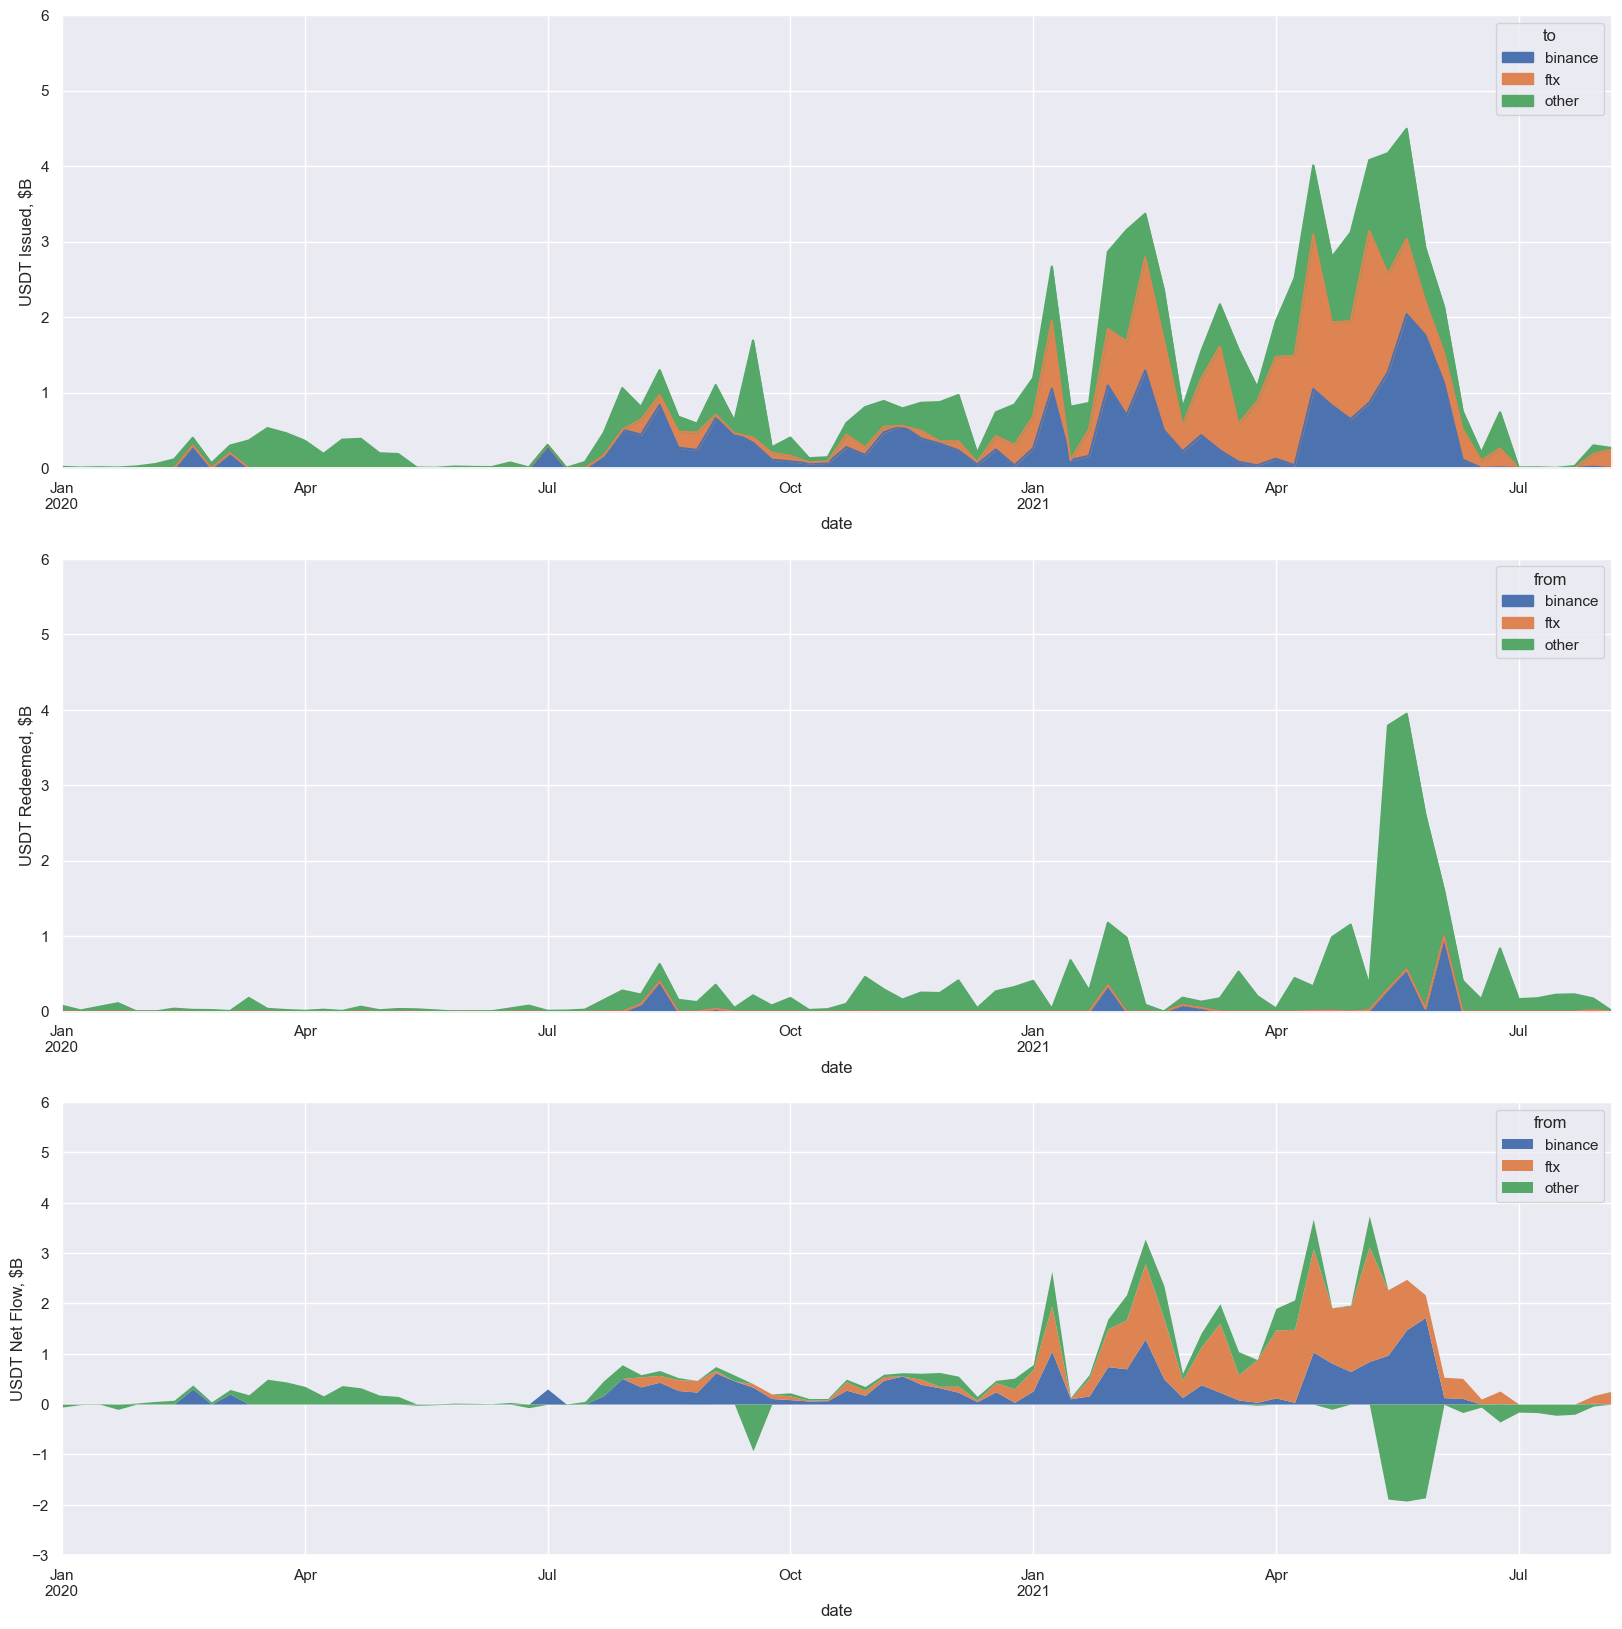

In [4]:
DATE_FROM = '2020-01-01'
DATE_TO = '2021-09-11'
RESOLUTION = "W"
MAX_Y = 6

### MAKE FIGURE
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (20, 20))
ax1.set_ylim([0,MAX_Y])
ax2.set_ylim([0,MAX_Y])
# ax3.set_ylim([-3,MAX_Y])

### ISSUANCE PLOT
dd = df.copy()

dd.loc[
        ~(df.to.isin(['ftx', 'binance']))
,"to"] = "other"

dd = dd.loc[
    (dd.date >= DATE_FROM) 
    & (dd.date < DATE_TO)
]

dd['date'] = dd.date.dt.to_period(RESOLUTION)
dd.value = dd.value.abs()

ddd = (dd.loc[
        dd['from'].str.contains('scrambler')
        & (dd.token == 'USDT')
    ]
   .groupby(['to', 'date'])
   .value.sum()
   .reset_index()
)

ddd = ddd.loc[~(ddd.to.str.contains('cold'))]
ddd.value /= 1_000_000_000

ax1.set_ylabel("USDT Issued, $B")

(ddd.pivot(index='date', columns='to', values='value')
    .fillna(0)
    .plot.area(ax=ax1)
)


### REDEMPTIONS
dd = df.copy()

dd = dd.loc[
    dd['to'].str.contains('scrambler')
    & (dd.token == 'USDT')
    & (~dd['from'].str.contains('mint'))
    & (~dd['from'].str.contains('cold'))
]

dd.loc[
    ~(df['from'].isin(['ftx', 'binance']))
, "from"] = "other"

dd = dd.loc[
    (dd.date >= DATE_FROM) 
    & (dd.date < DATE_TO)
]

dd['date'] = dd.date.dt.to_period(RESOLUTION)
dd.value = dd.value.abs()

ddd = (dd
   .groupby(['from', 'date'])
   .value.sum()
   .reset_index()
)

ddd = ddd.loc[~(ddd['from'].str.contains('cold'))]
ddd.value /= 1_000_000_000


ax2.set_ylabel("USDT Redeemed, $B")

(ddd.pivot(index='date', columns='from', values='value')
    .fillna(0)
    .plot.area(ax=ax2)
)

### NET
dd = df.loc[
    (  (df.to.str.contains('tether'))
       | (df['from'].str.contains('tether'))
    )
    & (df.token == 'USDT')
    & (~df['from'].str.contains('mint'))
    & (~df['from'].str.contains('cold'))
].copy()

dd['date'] = dd.date.dt.to_period(RESOLUTION)

# Get a column for who it's to/from (sign says which)
to_loc = dd.to.str.contains('tether')
from_loc = dd['from'].str.contains('tether')
dd.loc[to_loc, "to"] = dd.loc[to_loc, "from"]
dd.loc[from_loc, "from"] = dd.loc[from_loc, "to"]
dd = dd.drop(columns=['to'])
dd.loc[~(dd['from'].isin(['ftx', 'binance'])), "from"] = "other"

ddd = dd.groupby(['date', 'from']).sum().reset_index()

ddd.value /= 1_000_000_000

ax3.set_ylabel("USDT Net Flow, $B")

ddd = (ddd
    .pivot(index='date', columns='from', values='value')
    .fillna(0)
)

# split dataframe df into negative only and positive only values
df_neg, df_pos = ddd.clip(upper=0), ddd.clip(lower=0)
# stacked area plot of positive values
df_pos.plot.area(ax=ax3, stacked=True, linewidth=0.)
# reset the color cycle
ax3.set_prop_cycle(None)
# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(df_neg.rename(columns=lambda x: '_' + x)
       .plot.area(ax=ax3, stacked=True, linewidth=0.)
)

ax3.set_ylim([-3,MAX_Y])

### Finalize plot
plt.show()

# USDC Plot

/Users/mranger/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x124834f10> has a label of '_binance' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/mranger/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x126b1e190> has a label of '_ftx' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/mranger/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x128efa990> has a label of '_other' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/mranger/anaconda3/lib/python3.7/site-packages/pandas/plotting/_mat

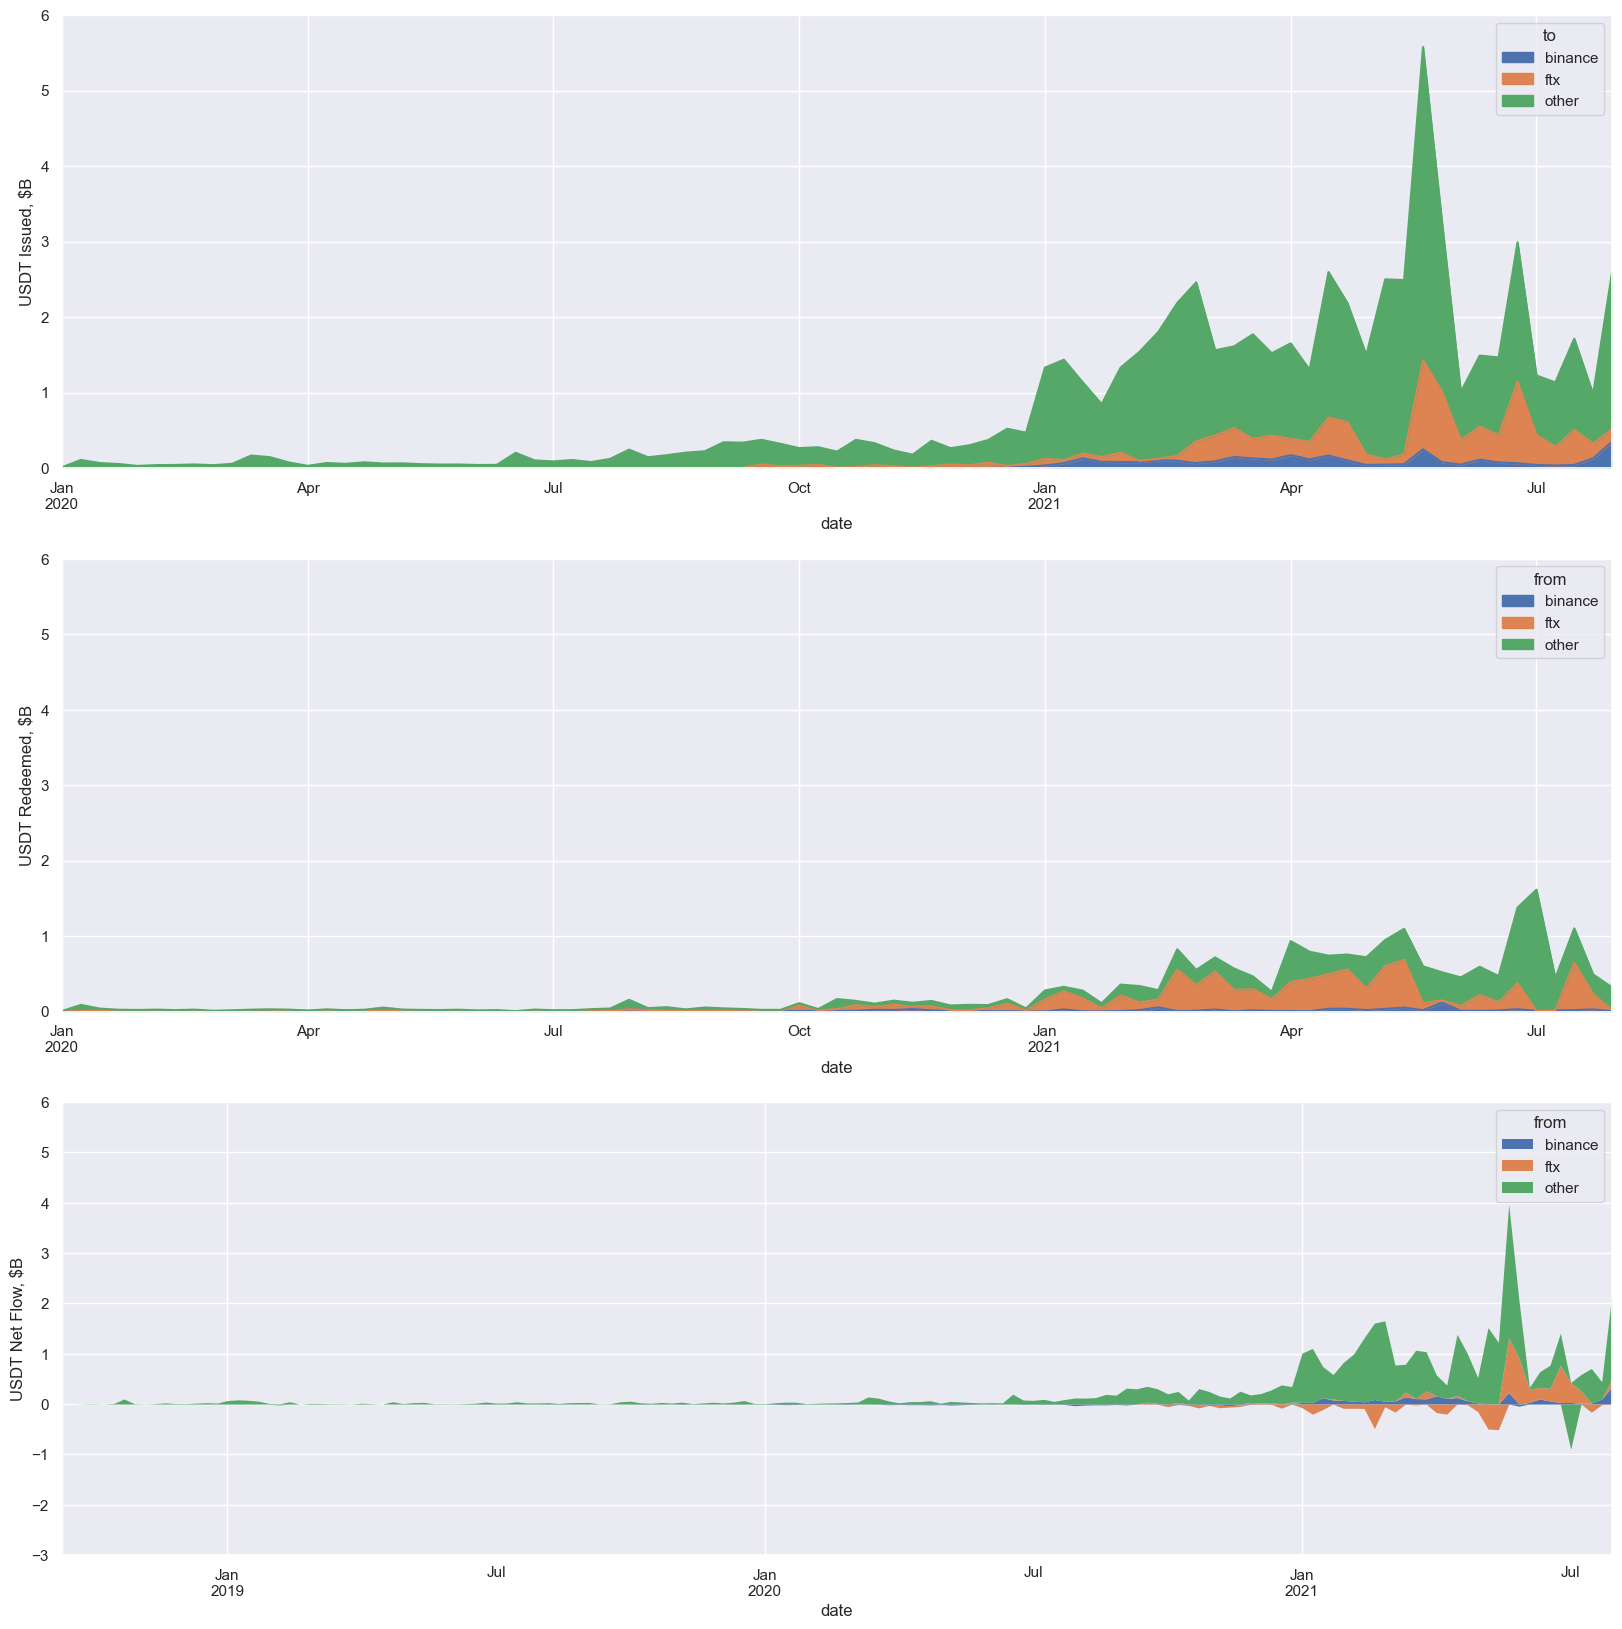

In [24]:
DATE_FROM = '2020-01-01'
DATE_TO = '2021-09-11'
RESOLUTION = "W"
MAX_Y = 6

### MAKE FIGURE
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (20, 20))
ax1.set_ylim([0,MAX_Y])
ax2.set_ylim([0,MAX_Y])
# ax3.set_ylim([-3,MAX_Y])

### ISSUANCE PLOT
dd = uc.copy()

dd = dd.loc[
    (dd.date >= DATE_FROM) 
    & (dd.date < DATE_TO)
]

dd['date'] = dd.date.dt.to_period(RESOLUTION)
dd.value = dd.value.abs()

dd = dd.loc[
    dd['from'].str.contains('usdc')
    & (~dd['to'].str.contains('null'))
    & (~dd['to'].str.contains('usdc'))
]

dd.loc[
        ~(dd.to.isin(['ftx', 'binance']))
,"to"] = "other"

ddd = (dd
   .groupby(['to', 'date'])
   .value.sum()
   .reset_index()
)

ddd = ddd.loc[~(ddd.to.str.contains('cold'))]
ddd.value /= 1_000_000_000

ax1.set_ylabel("USDT Issued, $B")

(ddd.pivot(index='date', columns='to', values='value')
    .fillna(0)
    .plot.area(ax=ax1)
)


### REDEMPTIONS
dd = uc.copy()

dd = dd.loc[
    dd['to'].str.contains('usdc')
    & (~dd['from'].str.contains('null'))
    & (~dd['from'].str.contains('usdc'))
]

dd.loc[
    ~(dd['from'].isin(['ftx', 'binance']))
, "from"] = "other"

dd = dd.loc[
    (dd.date >= DATE_FROM) 
    & (dd.date < DATE_TO)
]

dd['date'] = dd.date.dt.to_period(RESOLUTION)
dd.value = dd.value.abs()

ddd = (dd
   .groupby(['from', 'date'])
   .value.sum()
   .reset_index()
)

ddd = ddd.loc[~(ddd['from'].str.contains('cold'))]
ddd.value /= 1_000_000_000


ax2.set_ylabel("USDT Redeemed, $B")

(ddd.pivot(index='date', columns='from', values='value')
    .fillna(0)
    .plot.area(ax=ax2)
)

### NET
dd = uc.loc[
    (  (uc.to.str.contains('usdc'))
       | (uc['from'].str.contains('usdc'))
    )
    & (uc.token == 'USDC')
    & (~uc['from'].str.contains('null'))
    & (~uc['to'].str.contains('null'))
].copy()

dd['date'] = dd.date.dt.to_period(RESOLUTION)

# Get a column for who it's to/from (sign says which)
to_loc = dd.to.str.contains('usdc')
from_loc = dd['from'].str.contains('usdc')
dd.loc[to_loc, "to"] = dd.loc[to_loc, "from"]
dd.loc[from_loc, "from"] = dd.loc[from_loc, "to"]
dd = dd.drop(columns=['to'])
dd.loc[~(dd['from'].isin(['ftx', 'binance'])), "from"] = "other"

ddd = dd.groupby(['date', 'from']).sum().reset_index()

ddd.value /= 1_000_000_000

ax3.set_ylabel("USDT Net Flow, $B")

ddd = (ddd
    .pivot(index='date', columns='from', values='value')
    .fillna(0)
)

# split dataframe df into negative only and positive only values
df_neg, df_pos = ddd.clip(upper=0), ddd.clip(lower=0)
# stacked area plot of positive values
df_pos.plot.area(ax=ax3, stacked=True, linewidth=0.)
# reset the color cycle
ax3.set_prop_cycle(None)
# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(df_neg.rename(columns=lambda x: '_' + x)
       .plot.area(ax=ax3, stacked=True, linewidth=0.)
)

ax3.set_ylim([-3,MAX_Y])

### Finalize plot
plt.show()